In [73]:
%matplotlib inline

import numpy as np
import scipy as sp
from scipy import stats

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_context("poster") 

import dateutil
import datetime

import lifelines
import statsmodels.iolib.foreign as smio
from rpy2.robjects import pandas2ri, r

import re

import pudb

In [74]:
#function to read file and put into array & dataframe
def read_data(filename,col1="Size",col2="Bed",col3="Price"):
    data_arr = np.loadtxt(filename,delimiter=",")
    data_df = pd.DataFrame(data_arr)
    data_df.index = list(range(1, data_df.shape[0]+1))
    data_df.columns = list([col1,col2,col3])
    return data_arr,data_df

In [75]:
data_arr,data_df = read_data('ex1data2.txt')

In [162]:
# function to plot scatterplot for preliminary data view
def plot_data(data_arr_x,data_arr_y,x_label,y_label,x_scale,y_scale):
    fig, ax = plt.subplots()
    ax.scatter(data_arr_x/x_scale, data_arr_y/y_scale)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.xlim(min(data_arr_x/x_scale)-2,max(data_arr_x/x_scale)+2) 
    plt.ylim(min(data_arr_y/y_scale)-2,max(data_arr_y/y_scale)+2)
    
    print min(data_arr_y/y_scale)-2
    print max(data_arr_y/y_scale)+2
    
    find_grid_0 = np.where(ax.get_xticks() == 0)[0][0]
    find_grid_0 = find_grid_0.astype(int)
    
    x = ax.get_xgridlines()
    x_grid_0 = x[find_grid_0]
    x_grid_0.set_color('black')
    
    find_grid_0 = np.where(ax.get_yticks() == 0)[0][0]
    find_grid_0 = find_grid_0.astype(int)

    y = ax.get_ygridlines()
    y_grid_0 = y[find_grid_0]
    y_grid_0.set_color('black')


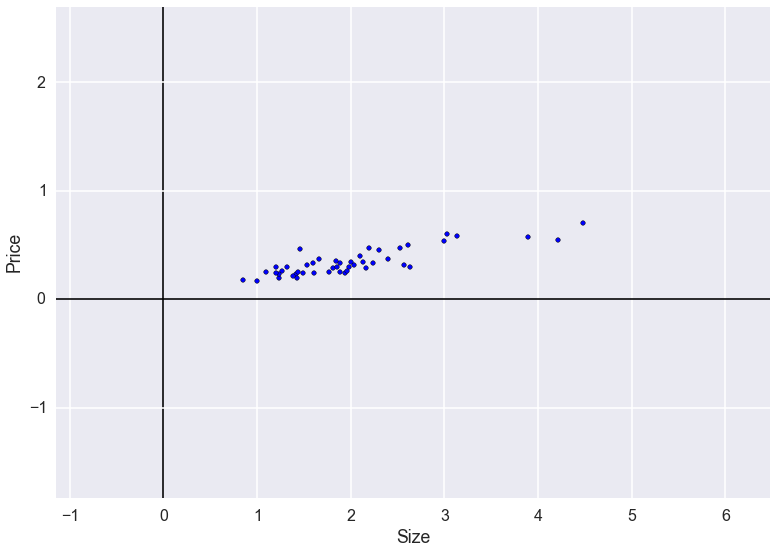

In [77]:
plot_data(data_arr[:,0],data_arr[:,2],"Size","Price",1000,1000000)

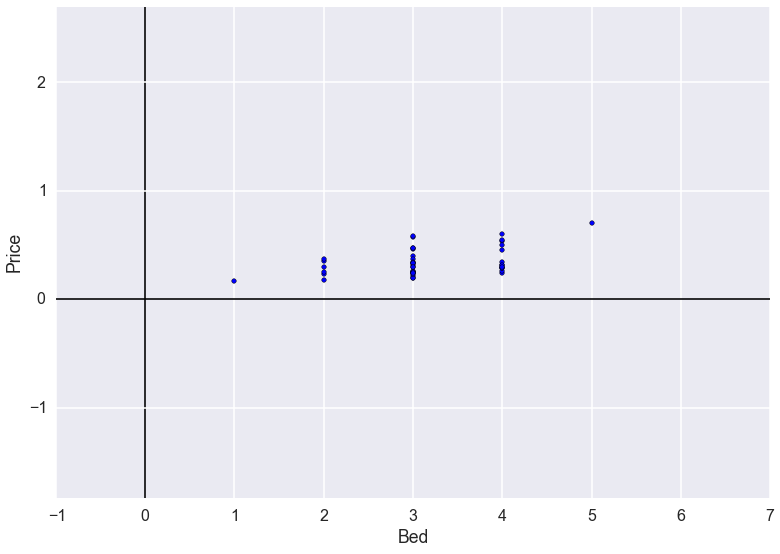

In [78]:
plot_data(data_arr[:,1],data_arr[:,2],"Bed","Price",1,1000000)

In [79]:
#get descriptive statistics into  a dataframe
desc_stats = pd.DataFrame(data_arr[:,:]).describe()
desc_stats = desc_stats.astype(int)
desc_stats.loc["median"] = pd.DataFrame(data_arr[:,:]).median()
desc_stats = desc_stats.reindex(["count", "mean", "median","std","min","25%","50%","75%","max"])
desc_stats

,0,1,2
count,47,47,47
mean,2000,3,340412
median,1888,3,299900
std,794,0,125039
min,852,1,169900
25%,1432,3,249900
50%,1888,3,299900
75%,2269,4,384450
max,4478,5,699900


In [80]:
#function that takes in data ndarray and returns arrays of examples(X), parameters(theta)
#and indicators(Y)
def make_X_theta_Y(data_arr,y_index):
    
    theta = np.zeros(shape=data_arr.shape[1])
    
    Y = data_arr[:,y_index]
    
    cols = data_arr.shape[1]
    cols = np.asarray(range(0,cols))
    
    X_Rest = data_arr[:,np.where(cols != y_index)]
    
    s1 = X_Rest.shape[0]
    s2 = X_Rest.shape[2]
    
    X_Rest = X_Rest.reshape((s1, s2))
    
    X_0 = np.ones(shape=s1)

    X = np.hstack((X_0[:, np.newaxis],X_Rest))
    
    return theta,X,Y


In [81]:
theta,X,Y = make_X_theta_Y(data_arr,2)

In [82]:
#function that takes in parameters(theta) and examples (X) and returns hypothesis (h)
def hypothesis(theta,X):
    h = np.dot(theta.T,X.T)
    return h

In [83]:
h = hypothesis(theta[:, np.newaxis],X)
h

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [84]:
#function that calculates the cost (J) from the hypothesis(h) and indicators(Y)
def error_cost(h,Y):
    
    a = h-Y
    b = a**2
    
    cost = b.sum()/(2*Y.shape[0])
    return cost

In [85]:
cost = error_cost(h,Y)
cost

65591548106.457443

In [224]:
#function that updates theta using batch gradient descent
def gradient_descent(theta,X,Y,alpha):
       
    h = hypothesis(theta,X)
    a = h-Y 
    
    g = np.zeros(theta.shape[0])
    
    for i in range(0,g.shape[0]):
        
        holder = a*X[:,i] 
        holder = holder.sum()
        holder = (holder*alpha)/(Y.shape[0])
        
        g[i] = holder

    new_theta = theta-g[:,np.newaxis]
    return new_theta

In [225]:
#set number of iterations of gradient descent to run and the value of alpha 
iterations = 1500
alpha = 0.00000001

In [226]:
#run gradient descent and save the changing values of the parameters(to_plot_0,to_plot_1)
#and cost (to_plot_j)

changing_theta = theta
theta_iter_i = changing_theta[:,np.newaxis]

changing_j = error_cost(hypothesis(theta_iter_i,X),Y)

for i in range(0,iterations):
    theta_iter_i = gradient_descent(theta_iter_i,X,Y,alpha) 

    changing_theta = np.hstack((changing_theta.reshape(3,i+1),theta_iter_i))
    
    s = error_cost(hypothesis(theta_iter_i,X),Y)
    changing_j = np.hstack((changing_j,s))


In [227]:
s = np.logical_not(np.isnan(changing_theta[1]))#.sum()

In [228]:
r = changing_theta[1][s]

In [229]:
r

array([   0.        ,    7.64209128,   14.93105306, ...,  165.38242706,
        165.38242678,  165.3824265 ])

In [230]:
r.max()

165.38274021951869

-2.0
167.382738979


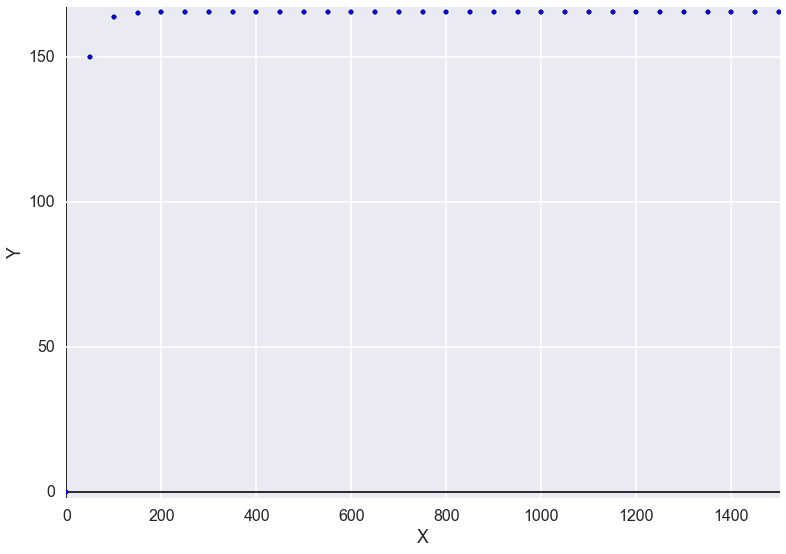

In [232]:
plot_data(np.asarray(range(0,len(r)))[0::50],r[0::50],"X","Y",1,1)

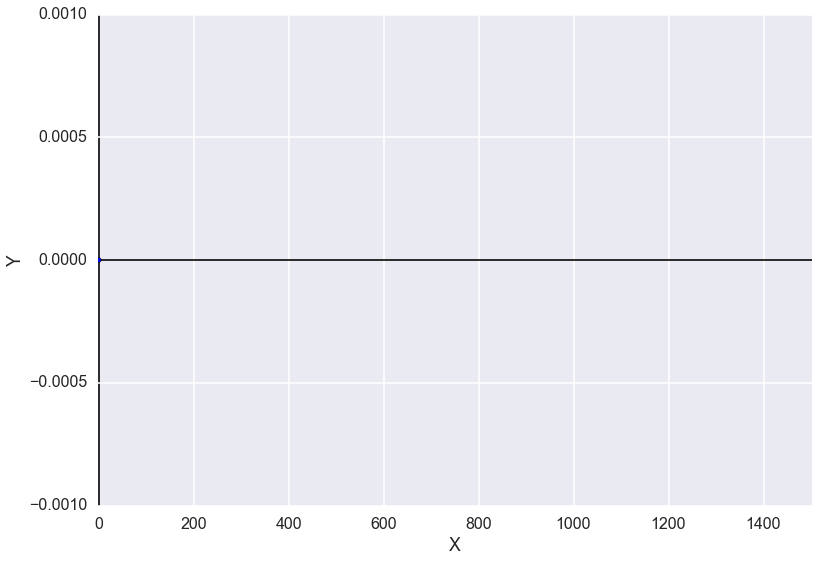

In [90]:
plot_data(np.asarray(range(0,changing_theta[0].shape[0])),changing_theta[0],"X","Y",1,1)

In [93]:
#r = theta[:,np.newaxis]
#p = theta[np.newaxis,:][:]
#f = np.hstack((r,r))
